In [1]:
import gym
import pickle
import numpy as np
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
from gym import envs

In [3]:
# env_name = 'CartPole-v0' #DONE
# env_name = 'MountainCar-v0' #DONE
# env_name = 'MountainCarContinuous-v0'
# env_name = 'Acrobot-v1' # DONE
# env_name = 'Pendulum-v0'
env_name = 'LunarLander-v2'
env = gym.make(env_name)

In [4]:
class Agent():
    def __init__(self, env):
        self.env = env
        
    def get_random_action(self, state):
        action = self.env.action_space.sample()
        return action

## Demo run

In [5]:
agent = Agent(env)
state = env.reset()
for i in range(1000): # run for 1000 steps
    env.render()
    action = agent.get_random_action(state) # pick a random action
    state, reward, terminal, info = env.step(action) # take action
    if terminal: 
        intial_state = env.reset()
env.close()

## Q-learning

In [46]:
class QAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
        self.q_table = {}
        self.num_states = self.env.action_space.n
        self.num_actions = env.action_space.n
        
    def transform_state(self, state):
        discreet_units = 10
        obs_range = env.observation_space.high - env.observation_space.low
        obs_range[obs_range == np.inf] = 3
        obs_range = np.array(obs_range) / discreet_units
        trans_state = tuple((np.array(state) / obs_range).astype(int))
        return trans_state
    
    def get_max_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = [0] * self.num_states # set 0 q-value for all acitons
            max_q_value = 0
        else:
            max_q_value = max(self.q_table[state])       
        return max_q_value
    
    def step(self, state, epsilon):
        state = self.transform_state(state)
        if state not in self.q_table:
            action = super().get_random_action(state)
            self.q_table[state] = [0] * self.num_actions # set 0 q-value for all acitons
            q_value = 0
        else:
            if np.random.random() < epsilon: # e-greedy
                action = super().get_random_action(state)
                q_value = self.q_table[state][action]
            else:
                action = np.argmax(self.q_table[state]) # get action with highest q-value
                q_value = max(self.q_table[state])            
        self.last_state = state
        self.last_action = action
        self.last_q_value = q_value
        return action
                
    def update_q_table(self, state, step_size, reward, gamma):
        state = self.transform_state(state)
        max_q_value = agent.get_max_q(state)
        agent.q_table[self.last_state][self.last_action] += round(step_size * 
                                                                  (reward + gamma * max_q_value - self.last_q_value), 1)

In [36]:
agent = QAgent(env)
step_size = 0.05
epsilon = 1
gamma = 1

In [44]:
step_size = 0.01

In [45]:
# q_table = {}
highscores = []
timesteps = [0]
epsilons = []
stepsizes = []

# while np.mean(timesteps[-1000:]) < 198:
for i_episode in range(20000): # run 20 episodes
    state = env.reset()
    points = 0 # keep track of the reward each episode
    steps = 0
    while True: # run until episode is done
        #env.render()
        
        action = agent.step(state, epsilon)
        state, reward, terminal, info = env.step(action)
        agent.update_q_table(state, step_size, reward, gamma)
        
        steps += 1
        points += reward
        if terminal:
            highscores.append(points)
            timesteps.append(steps)
            epsilons.append(epsilon)
            stepsizes.append(step_size)
            epsilon *=   0.9999    
            step_size *=   0.99993
            #epsilon *=   0.99993
            #step_size *=   0.99999
            break
            
    clear_output(wait=True)
    print('run avg score:', np.mean(highscores[-1000:]))
    print('run avg timesteps:', np.mean(timesteps[-1000:]))
    print('episodes:', len(timesteps))
    print('epsilon:', epsilon, 'step_size:', step_size)
    
env.close()
#print('highscores:', max(highscores),'mean:', np.mean(highscores))
print('timesteps:', max(timesteps),'mean:', np.mean(timesteps))
print(epsilon, step_size)

run avg score: -46.15744940776592
run avg timesteps: 155.669
episodes: 1075
epsilon: 0.21503018827639755 step_size: 0.009275740666867795


KeyboardInterrupt: 

In [390]:
# polecart_file = open('polecart_q_table.pkl', 'wb')
# pickle.dump(agent.q_table, polecart_file)

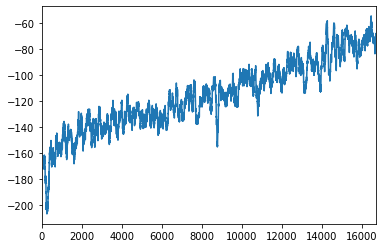

In [35]:
timesteps_series = pd.Series(highscores)
timesteps_ma = timesteps_series.rolling(window=100).mean()
timesteps_ma.plot()

In [14]:
epsilon = 0
timesteps = []
highscores = []
for i_episode in range(2): # run 20 episodes
    state = env.reset()
    steps = 0
    points = 0
    while True: # run until episode is done
        env.render()
        
        action = agent.step(state, epsilon)
        state, reward, terminal, info = env.step(action)
        
        steps += 1
        points += reward
        if terminal:
            highscores.append(points)
            timesteps.append(steps)
            break

env.close()
print(timesteps)
print(highscores)

[196, 272]
[42.92134540002948, 250.81179072065805]


In [110]:
agent.q_table

{(0, 0, 0, 0): [950.500000002458, 943.4000000024911],
 (0, -1, 0, 1): [940.2000000009599, 951.4000000012103],
 (0, 0, 0, -1): [941.4000000014416, 870.000000000011],
 (0, 1, 0, -1): [946.0000000012475, 929.1000000009092],
 (0, -2, 0, 2): [896.3000000000421, 936.7000000006028],
 (0, -2, 0, 3): [832.8999999999992, 943.3000000000231],
 (0, -3, 0, 4): [462.5000000000002, 895.299999999999],
 (0, -4, 1, 5): [40.1, 457.09999999999997],
 (0, -3, 1, 5): [104.90000000000002, 416.6000000000001],
 (0, -2, 1, 4): [274.5999999999999, 686.2000000000007],
 (0, -3, 2, 5): [32.4, 264.5999999999999],
 (0, -2, 2, 4): [158.9, 333.29999999999995],
 (0, 0, 0, 1): [943.4000000000116, 950.0000000013185],
 (0, 1, 0, -2): [942.0000000003878, 916.3000000000145],
 (0, 1, 0, -3): [852.8000000000025, 569.1],
 (0, 2, 0, -4): [649.7000000000002, 363.19999999999993],
 (0, 3, -1, -5): [503.09999999999997, 89.70000000000005],
 (0, 2, -1, -4): [722.1, 297.50000000000006],
 (0, 3, -2, -6): [94.4, 11.400000000000006],
 (0, 3